In [1]:
!pip install cleverhans

     |████████████████████████████████| 204kB 2.8MB/s 
     |████████████████████████████████| 163kB 55.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

TensorFlow 1.x selected.


--- Create and Train a Simple MNIST CNN Classifier ---

In [0]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [0]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [5]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

sess = tf.Session()
keras.backend.set_session(sess)

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 33s 554us/sample - loss: 1.0316 - categorical_accuracy: 0.6688 - val_loss: 0.3295 - val_categorical_accuracy: 0.9088
Epoch 2/12
60000/60000 [==============================] - 32s 541us/sample - loss: 0.5083 - categorical_accuracy: 0.8419 - val_loss: 0.2606 - val_categorical_accuracy: 0.9275
Epoch 3/12
60000/60000 [==============================] - 32s 542us/sample - loss: 0.4331 - categorical_accuracy: 0.8665 - val_loss: 0.2265 - val_categorical_accuracy: 0.9365
Epoch 4/12
60000/60000 [==============================] - 32s 540us/sample - loss: 0.3819 - categorical_accuracy: 0.8839 - val_loss: 0.1994 - val_categorical_accuracy: 0.9421
Epoch 5/12
60000/60000 [==============================] - 33s 548us/sample - loss: 0.3453 - categorical_accuracy: 0.8951 - val_loss: 0.1804 - val_categorical_accuracy: 0

--- Attack the Model ---

In [0]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [0]:
import cleverhans
from cleverhans.attacks import BasicIterativeMethod
wrap = cleverhans.model.CallableModelWrapper(keras.Model(inputs=model.input, outputs=model.layers[-2].output),'logits')
attack = BasicIterativeMethod(wrap, sess=sess)
params = {'eps': 0.3,
          'eps_iter':0.05,
          'clip_min': 0.,
          'clip_max': 1.
         }
adv_images = attack.generate_np(test_images, **params)

[INFO 2020-03-31 19:50:33,781 cleverhans] Constructing new graph for attack BasicIterativeMethod





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
dim is deprecated, use axis instead


Test loss: 8.38
Successfully moved out of source class: 0.98
Mean perturbation distance: 0.19


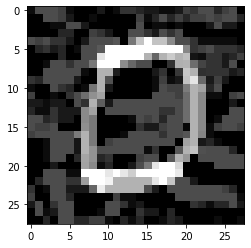

In [0]:
TestAttack(model, adv_images, test_images, test_labels, targeted=False)

--- And now with a targeted BIM attack ---

In [0]:
attack = BasicIterativeMethod(wrap, sess=sess)
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
params = {'eps': 0.3,
          'eps_iter':0.05,
          'clip_min': 0.,
          'clip_max': 1.,
          'y_target':target
         }
adv_images = attack.generate_np(test_images, **params)

[INFO 2020-03-31 19:51:09,769 cleverhans] Constructing new graph for attack BasicIterativeMethod


Test loss: 5.45
Successfully moved out of source class: 0.99
Test loss: 0.13
Successfully perturbed to target class: 0.98
Mean perturbation distance: 0.19


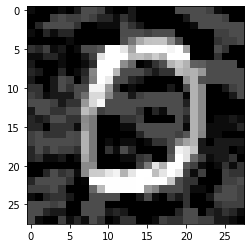

In [0]:
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)